In [2]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import seaborn as sns
import pandas as pd
import numpy as np

from typing import Callable

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

from src.clustering import GeneralClustererFinder

# Reading the data

For better clustering exploration I will merge the two labeled data files we currently have and merge them into a 2d series.

Since we cannot meaningfully merge two entries from different repeated experiments, I will use average VALUE of a given compound in an experiment as one dimension.

In [3]:
data_ros1 = pd.read_excel("../data/raw/ROS1_DTT_fanonymised_limited.xlsx")
data_ros2 = pd.read_excel("../data/raw/ROS2_HRP anonymised limited.xlsx")

In [16]:
mean_value_ros1 = data_ros1.groupby("DTT  - compound ID").mean(numeric_only=True)["VALUE"].rename("DTT_VALUE")
mean_value_ros2 = data_ros2.groupby("HRP - compound ID").mean(numeric_only=True)["VALUE"].rename("HRP_VALUE")

qt_dtt = QuantileTransformer()
qt_hrp = QuantileTransformer()

mean_value_merged = pd.concat([mean_value_ros1, mean_value_ros2], axis=1).dropna()
mean_value_q_ros1 = qt_dtt.fit_transform(mean_value_merged["DTT_VALUE"].to_numpy().reshape(-1, 1)).flatten()
mean_value_q_ros2 = qt_hrp.fit_transform(mean_value_merged["HRP_VALUE"].to_numpy().reshape(-1, 1)).flatten()
mean_value_merged["DTT_VALUE_Q"] = mean_value_q_ros1
mean_value_merged["HRP_VALUE_Q"] = mean_value_q_ros2
value_series = mean_value_merged[["DTT_VALUE_Q", "HRP_VALUE_Q"]].to_numpy()

# Data Clustering Parameters Setup

I will use GeneralClustererFinder on the following three algorithms:
-   Affitiy Propagation
-   KMeans
-   GaussianMixture

In [17]:
RANDOM_STATE = 31
CLUSTERING_CONFIG = [
    {
        "name": "AffinityPropagation",
        "clusterer": AffinityPropagation(),
        "param_grid": ParameterGrid({
            "damping": [0.5, 0.75, 0.9, 0.95],
            "random_state": [RANDOM_STATE]
        }),
    },
    {
        "name": "KMeans",
        "clusterer": KMeans(),
        "param_grid": ParameterGrid({
            "n_clusters": range(2, 16),
            "random_state": [RANDOM_STATE]
        }),
    },
    {
        "name": "GaussianMixture",
        "clusterer": GaussianMixture(),
        "param_grid": ParameterGrid({
            "n_components": range(2, 16),
            "random_state": [RANDOM_STATE]
        }),
    }
]

In [143]:
def evaluate_with_metric(data_series: np.ndarray, metric: Callable[[np.ndarray, np.ndarray], float], index: pd.Series) -> pd.DataFrame:
    df = pd.DataFrame(index=index)
    for config in CLUSTERING_CONFIG:
        print(f"==== CLUSTERING WITH {config['name']} ====")
        clusterer_finder = GeneralClustererFinder(
            param_grid=config["param_grid"],
            clusterer=config["clusterer"],
            scoring_function=metric
        )
        clusterer_finder.cluster_data_series(data_series, verbose=True)
        df[f"labels_{config['name']}"] = clusterer_finder.cached_best_prediction
    return df

def summarize_clustering(values: np.ndarray, labels: np.ndarray) -> None:
    all_labels = np.unique(labels).flatten()
    for label in all_labels:
        label_values = values[labels.flatten() == label]
        print(f"Cluster {label}: {len(label_values)} values")
        print(f"\tMean: {np.mean(label_values, axis=0)}")
        print(f"\tStd: {np.std(label_values, axis=0)}")
        print(f"\tMin: {np.min(label_values, axis=0)}")
        print(f"\tMax: {np.max(label_values, axis=0)}")
        print()


## Clustering results using Silhouette Score

In [ ]:
ss_results = evaluate_with_metric(value_series, metrics.silhouette_score, mean_value_merged.index)

==== CLUSTERING WITH AffinityPropagation ====


d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Params: {'damping': 0.5, 'random_state': 31} | Score: 0.24736077859844052
Params: {'damping': 0.75, 'random_state': 31} | Score: 0.35226919158873615
Params: {'damping': 0.9, 'random_state': 31} | Score: 0.35350742858268364
Params: {'damping': 0.95, 'random_state': 31} | Score: 0.3542659542459933

DONE

Best Score: 0.3542659542459933
Best Params: {'damping': 0.95, 'random_state': 31}
==== CLUSTERING WITH KMeans ====
Params: {'n_clusters': 2, 'random_state': 31} | Score: 0.38043246440401535
Params: {'n_clusters': 3, 'random_state': 31} | Score: 0.3876806182378066
Params: {'n_clusters': 4, 'random_state': 31} | Score: 0.41125265702973895
Params: {'n_clusters': 5, 'random_state': 31} | Score: 0.397269223818873
Params: {'n_clusters': 6, 'random_state': 31} | Score: 0.38160046220887495
Params: {'n_clusters': 7, 'random_state': 31} | Score: 0.36293213220286563
Params: {'n_clusters': 8, 'random_state': 31} | Score: 0.37225598987999714
Params: {'n_clusters': 9, 'random_state': 31} | Score: 0.37

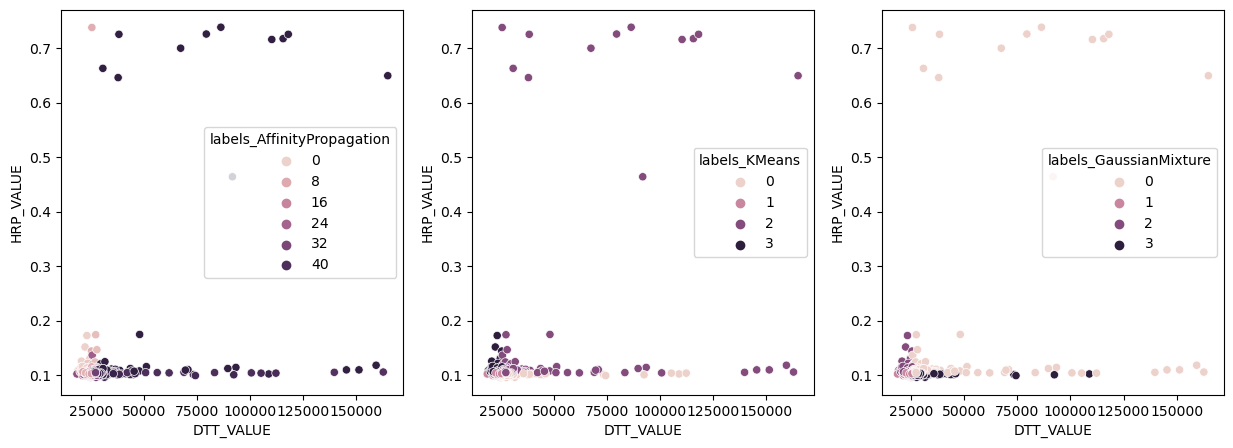

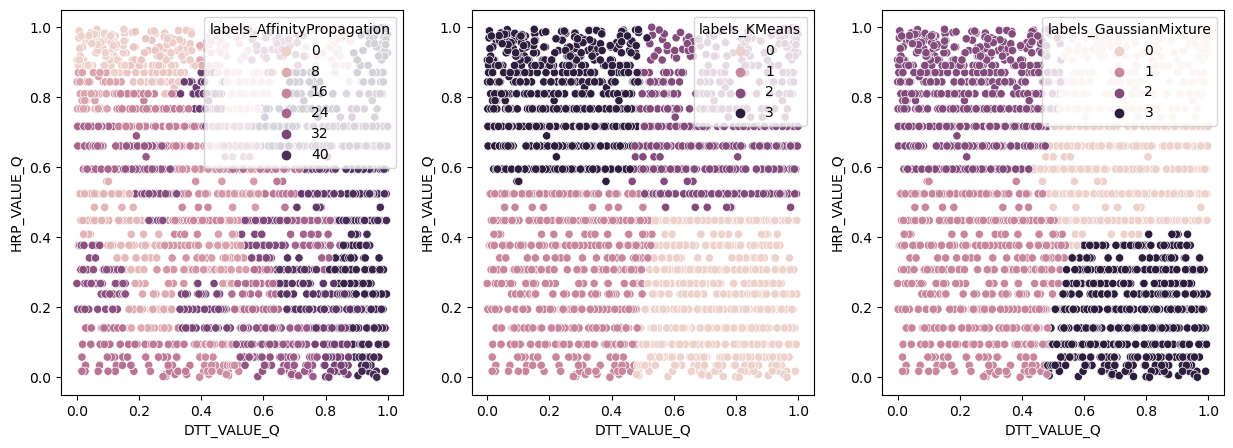

In [80]:
ss_scores_merged = pd.concat([mean_value_merged, ss_results], axis=1)

fig, ax = plt.subplots(1, 3, figsize =(15, 5))
for config, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(ss_scores_merged, x="DTT_VALUE", y="HRP_VALUE", hue=f"labels_{config['name']}", ax=subplt)

fig, ax = plt.subplots(1, 3, figsize =(15, 5))
for config, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(ss_scores_merged, x="DTT_VALUE_Q", y="HRP_VALUE_Q", hue=f"labels_{config['name']}", ax=subplt)

In [144]:
summarize_clustering(ss_scores_merged[["DTT_VALUE", "HRP_VALUE"]].to_numpy(), ss_scores_merged[["labels_AffinityPropagation"]].to_numpy())

Cluster 0: 79 values
	Mean: [2.22873797e+04 1.12886076e-01]
	Std: [8.63962835e+02 8.91235431e-03]
	Min: [1.90405e+04 1.07500e-01]
	Max: [2.34335e+04 1.72500e-01]

Cluster 1: 41 values
	Mean: [2.44699878e+04 1.13036585e-01]
	Std: [2.00544882e+02 6.43010284e-03]
	Min: [2.39985e+04 1.07000e-01]
	Max: [2.4802e+04 1.3050e-01]

Cluster 2: 67 values
	Mean: [2.39053955e+04 1.08671642e-01]
	Std: [2.94253122e+02 2.86844937e-03]
	Min: [2.32815e+04 1.06500e-01]
	Max: [2.44205e+04 1.23500e-01]

Cluster 3: 46 values
	Mean: [2.56501522e+04 1.06641304e-01]
	Std: [2.13319007e+02 4.85250311e-04]
	Min: [2.53225e+04 1.06000e-01]
	Max: [2.60845e+04 1.07500e-01]

Cluster 4: 29 values
	Mean: [2.76469655e+04 1.14517241e-01]
	Std: [3.66101760e+02 1.35560667e-02]
	Min: [2.69095e+04 1.07000e-01]
	Max: [2.82655e+04 1.74000e-01]

Cluster 5: 45 values
	Mean: [2.35115111e+04 1.02900000e-01]
	Std: [3.69765083e+02 3.59010987e-04]
	Min: [2.26975e+04 1.02500e-01]
	Max: [2.4133e+04 1.0350e-01]

Cluster 6: 57 values
	Mean

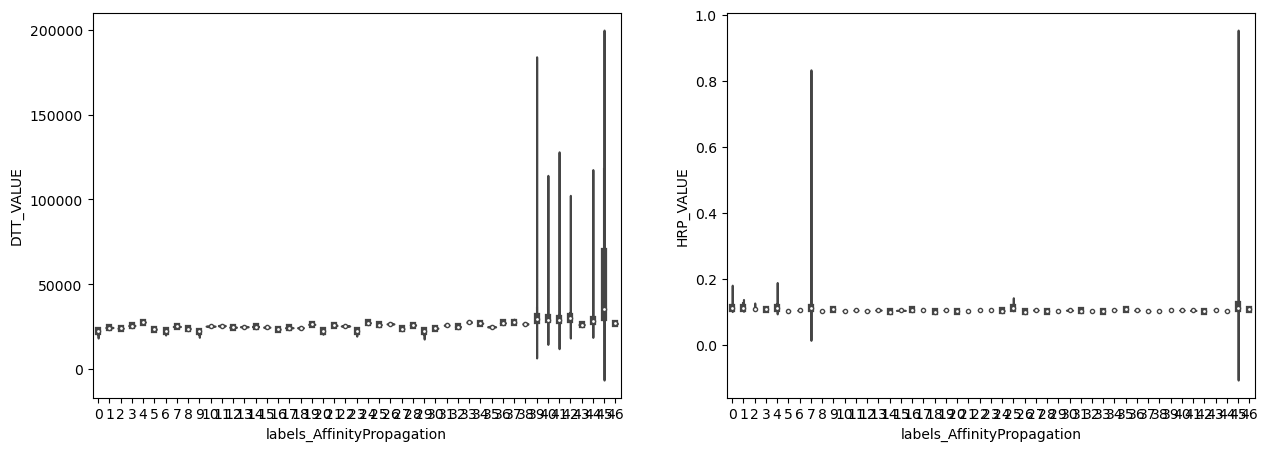

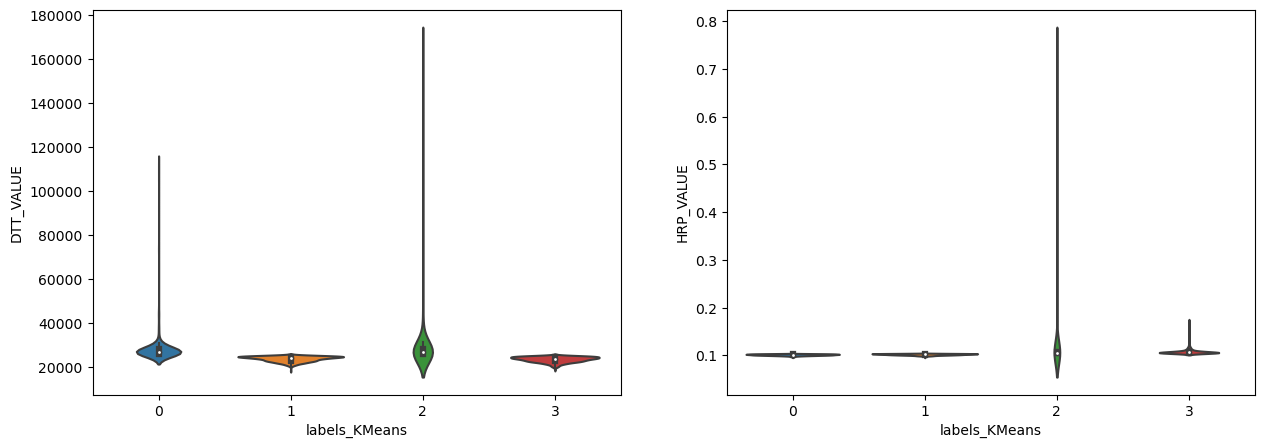

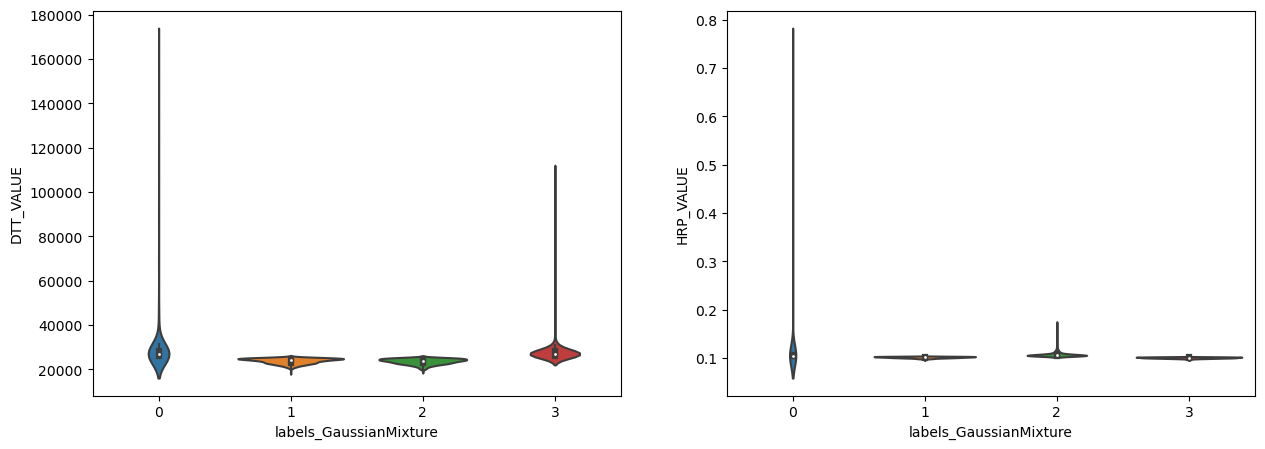

In [88]:
kmeans_grouped = ss_scores_merged.groupby("labels_KMeans").mean()
for config in CLUSTERING_CONFIG:
    fig, ax = plt.subplots(1, 2, figsize =(15, 5))
    sns.violinplot(ss_scores_merged, x="labels_"+config['name'], y="DTT_VALUE", ax=ax[0])
    sns.violinplot(ss_scores_merged, x="labels_"+config['name'], y="HRP_VALUE", ax=ax[1])

In [117]:
COLORS = ["red", "green", "blue", "yellow", "orange", "purple"]

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


(0.075, 0.12)

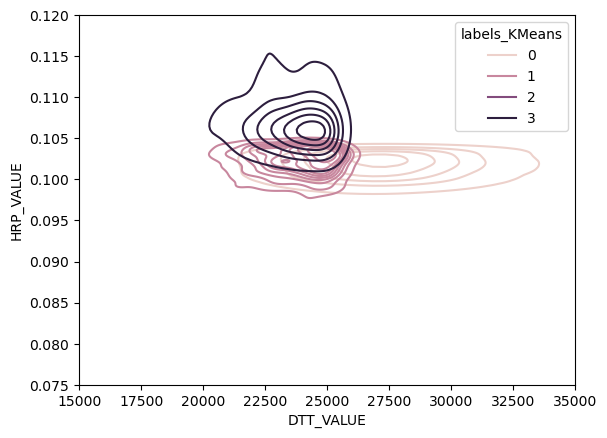

In [132]:
sns.kdeplot(ss_scores_merged, x="DTT_VALUE", y="HRP_VALUE", hue="labels_KMeans")
plt.xlim(15_000, 35_000)
plt.ylim(0.075, 0.12)


d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


(0.075, 0.12)

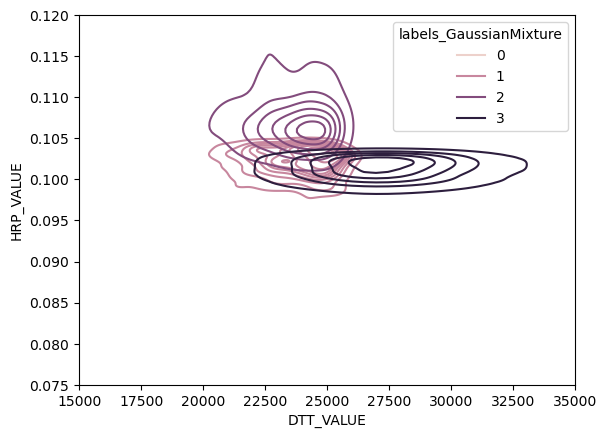

In [136]:
sns.kdeplot(ss_scores_merged, x="DTT_VALUE", y="HRP_VALUE", hue="labels_GaussianMixture")
plt.xlim(15_000, 35_000)
plt.ylim(0.075, 0.12)

## Clustering results using Davies-Bouldin score

In [138]:
def negated_davies_bouldin(*args, **kwargs) -> float:
    return -metrics.davies_bouldin_score(*args, **kwargs)

db_results = evaluate_with_metric(value_series, negated_davies_bouldin, mean_value_merged.index)

==== CLUSTERING WITH AffinityPropagation ====


d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Params: {'damping': 0.5, 'random_state': 31} | Score: -0.4647503957520273
Params: {'damping': 0.75, 'random_state': 31} | Score: -0.8090406614238185
Params: {'damping': 0.9, 'random_state': 31} | Score: -0.8050386107688906
Params: {'damping': 0.95, 'random_state': 31} | Score: -0.8047128624741524

DONE

Best Score: -0.4647503957520273
Best Params: {'damping': 0.5, 'random_state': 31}
==== CLUSTERING WITH KMeans ====
Params: {'n_clusters': 2, 'random_state': 31} | Score: -1.075604139368749
Params: {'n_clusters': 3, 'random_state': 31} | Score: -0.8630380732588095
Params: {'n_clusters': 4, 'random_state': 31} | Score: -0.7757267203782561
Params: {'n_clusters': 5, 'random_state': 31} | Score: -0.8457942418060049
Params: {'n_clusters': 6, 'random_state': 31} | Score: -0.8585928386410542
Params: {'n_clusters': 7, 'random_state': 31} | Score: -0.8883868201649332
Params: {'n_clusters': 8, 'random_state': 31} | Score: -0.8062907223577461
Params: {'n_clusters': 9, 'random_state': 31} | Score: -

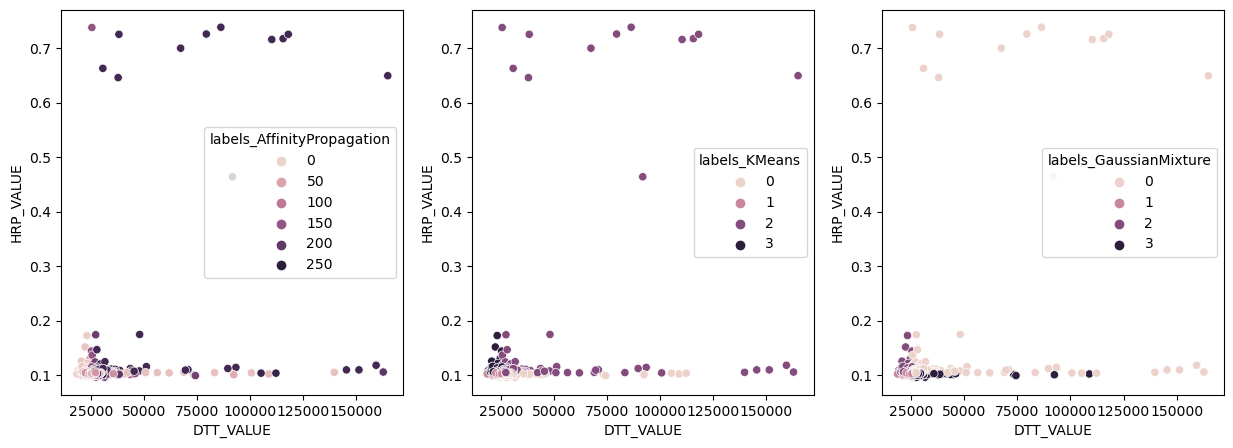

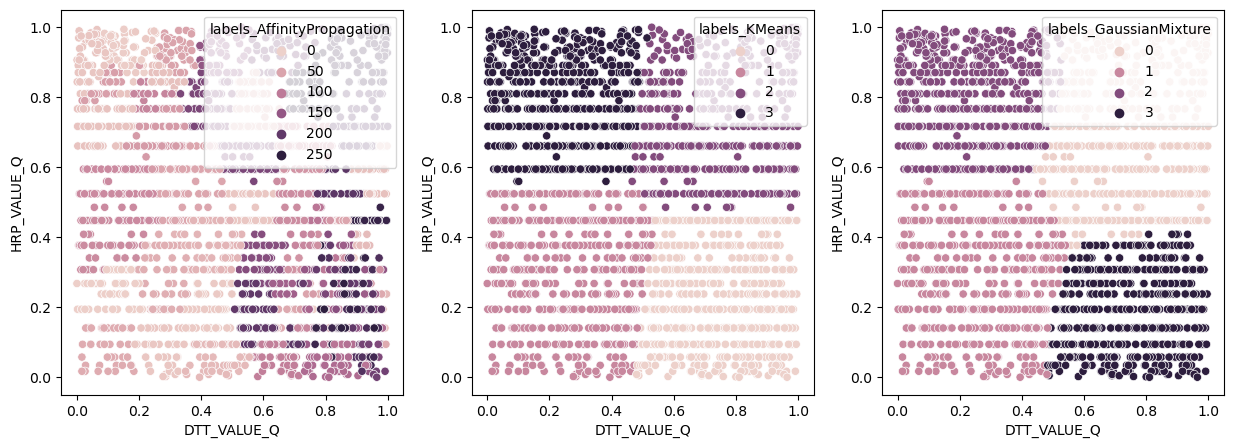

In [139]:
db_scores_merged = pd.concat([mean_value_merged, db_results], axis=1)

fig, ax = plt.subplots(1, 3, figsize =(15, 5))
for config, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(db_scores_merged, x="DTT_VALUE", y="HRP_VALUE", hue=f"labels_{config['name']}", ax=subplt)

fig, ax = plt.subplots(1, 3, figsize =(15, 5))
for config, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(db_scores_merged, x="DTT_VALUE_Q", y="HRP_VALUE_Q", hue=f"labels_{config['name']}", ax=subplt)

In [146]:
summarize_clustering(ss_scores_merged[["DTT_VALUE", "HRP_VALUE"]].to_numpy(), ss_scores_merged[["labels_KMeans"]].to_numpy())

Cluster 0: 653 values
	Mean: [2.81722649e+04 1.01562021e-01]
	Std: [6.97370958e+03 1.39636266e-03]
	Min: [2.5301e+04 9.6000e-02]
	Max: [1.12273e+05 1.03500e-01]

Cluster 1: 576 values
	Mean: [2.38838924e+04 1.02220486e-01]
	Std: [1.19808069e+03 1.40312045e-03]
	Min: [1.8508e+04 9.6000e-02]
	Max: [2.5585e+04 1.0400e-01]

Cluster 2: 540 values
	Mean: [3.08762167e+04 1.19496296e-01]
	Std: [1.69694521e+04 8.60032675e-02]
	Min: [2.52185e+04 1.03500e-01]
	Max: [1.649725e+05 7.385000e-01]

Cluster 3: 607 values
	Mean: [2.36400486e+04 1.07827018e-01]
	Std: [1.22170604e+03 5.36337523e-03]
	Min: [1.90405e+04 1.04000e-01]
	Max: [2.54565e+04 1.72500e-01]



In [147]:
summarize_clustering(ss_scores_merged[["DTT_VALUE", "HRP_VALUE"]].to_numpy(), ss_scores_merged[["labels_GaussianMixture"]].to_numpy())

Cluster 0: 630 values
	Mean: [3.06398444e+04 1.17132540e-01]
	Std: [1.63767947e+04 7.98314910e-02]
	Min: [2.5126e+04 1.0300e-01]
	Max: [1.649725e+05 7.385000e-01]

Cluster 1: 581 values
	Mean: [2.38884122e+04 1.02207401e-01]
	Std: [1.20134275e+03 1.41102017e-03]
	Min: [1.8508e+04 9.6000e-02]
	Max: [2.5638e+04 1.0400e-01]

Cluster 2: 612 values
	Mean: [2.36677042e+04 1.07861111e-01]
	Std: [1.23553389e+03 5.33106484e-03]
	Min: [1.90405e+04 1.04500e-01]
	Max: [2.5517e+04 1.7250e-01]

Cluster 3: 553 values
	Mean: [2.80458825e+04 1.01249548e-01]
	Std: [5.75811513e+03 1.25541315e-03]
	Min: [2.53145e+04 9.60000e-02]
	Max: [1.08894e+05 1.03000e-01]



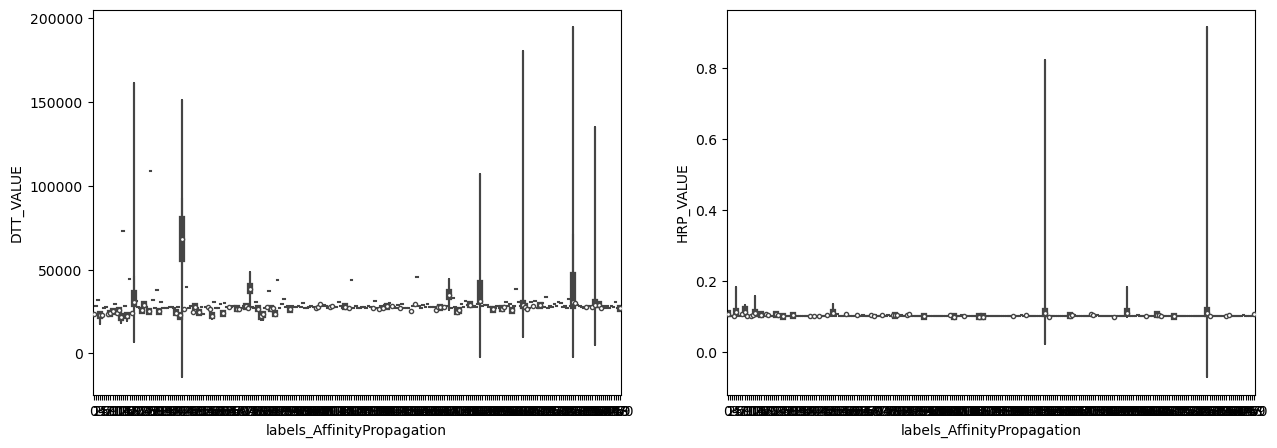

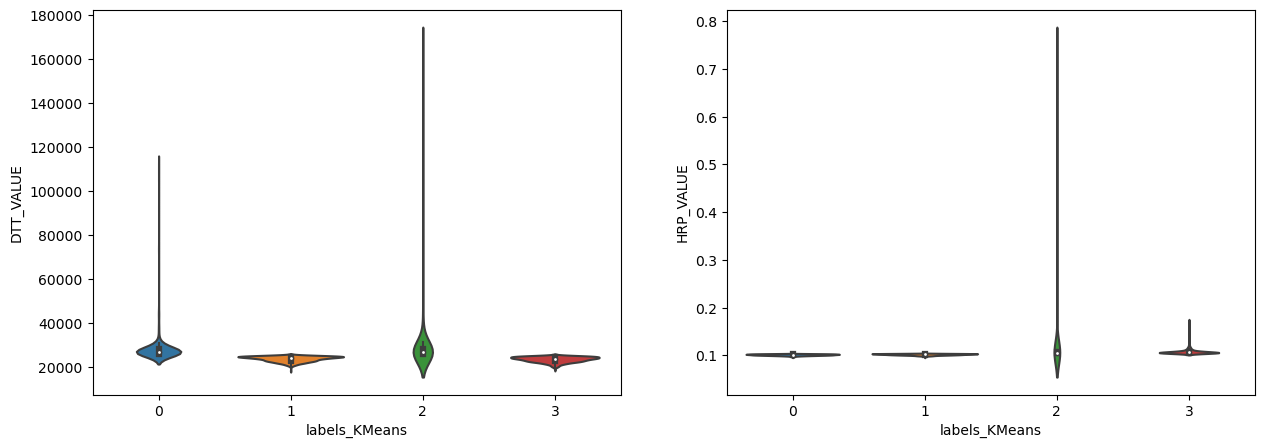

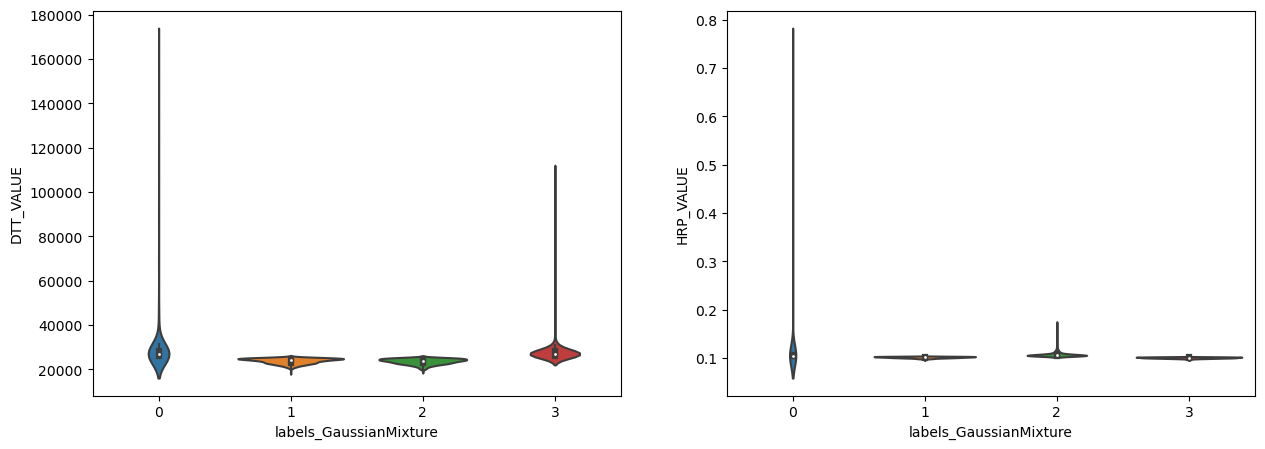

In [153]:
for config in CLUSTERING_CONFIG:
    fig, ax = plt.subplots(1, 2, figsize =(15, 5))
    sns.violinplot(db_scores_merged, x="labels_"+config['name'], y="DTT_VALUE", ax=ax[0])
    sns.violinplot(db_scores_merged, x="labels_"+config['name'], y="HRP_VALUE", ax=ax[1])